In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import anndata
import dynamo as dyn
dyn.get_all_dependencies_version()

2023-12-12 14:47:54.676439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 14:47:55.731285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


package,tqdm,statsmodels,setuptools,scipy,scikit-learn,pandas,numpy,networkx,matplotlib,anndata,igraph,loompy,numdifftools,umap-learn,numba,seaborn,colorcet,pynndescent,pre-commit,get-version,openpyxl,typing-extensions,session-info,dynamo-release
version,4.65.0,0.14.0,68.0.0,1.10.0,1.2.2,1.5.3,1.22.3,2.8.4,3.7.1,0.9.1,0.10.4,3.0.7,0.9.41,0.5.3,0.56.4,0.12.2,3.0.1,0.5.8,3.2.0,3.5.4,3.2.0b1,4.5.0,1.0.0,1.3.3


In [6]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

Running scvelo 0.2.5 (python 3.10.11) on 2023-12-12 14:57.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [2]:
adata = anndata.read("mouse_retina.h5ad")

In [3]:
dyn.pp.recipe_monocle(adata)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> filtering cells...
|-----> 2683 cells passed basic filters.
|-----> filtering gene...
|-----> 4836 genes passed basic filters.
|-----> calculating size factor...
|-----> selecting genes in layer: X, sort method: SVR...
|-----> size factor normalizing the data, followed by log1p transformation.

In [8]:
dyn.tl.reduceDimension(adata)

|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [UMAP] completed [0.2035s]


In [10]:
dyn.tl.dynamics(adata, model='stochastic', cores=100)
dyn.tl.cell_velocities(adata, method='cosine')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [13.2052s]
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via cosine kernel with sqrt transform.] completed [1.3769s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.5837s]


AnnData object with n_obs × n_vars = 2726 × 31053
    obs: 'Clusters', 'Annotation', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'ntr', 'cell_cycle_phase', 'S_score', 'G2M_score', 'phase', 'clusters_gradients'
    var: 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'paper_review_url', 'paper_url', 'pp', 'velocyto_SVR', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'cell_phase_genes', 'clusters_gradients_colors', 'neighbors', 'dynamics', 'grid_velocity_umap'
    obsm: 'X_umap', 'X_pca', 'X', 'cell_cycle_scores', 'velocity_umap'
   

In [11]:
scv.tl.velocity_graph(adata, vkey='velocity_S', xkey='M_s', n_jobs=100)

computing velocity graph (using 100/192 cores)


  0%|          | 0/2726 [00:00<?, ?cells/s]

    finished (0:07:28) --> added 
    'velocity_S_graph', sparse matrix with cosine correlations (adata.uns)


In [18]:
scv.tl.velocity_pseudotime(adata, vkey='velocity_S', 
                           #root_key='end',
                           #end_key='root',
                           n_dcs=20,
                          )

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [23]:
Progenitor=adata.obs.query("Annotation=='Progenitor'")
root_cells=adata.obs['root_cells'][Progenitor.index]
adata.obs['root']=root_cells

In [24]:
endcell=adata.obs.query("Annotation=='PR' or Annotation=='AC/HC' or Annotation=='RGC'")
end_cells=adata.obs['end_points'][endcell.index]
adata.obs['end']=end_cells

In [25]:
scv.tl.velocity_pseudotime(adata, vkey='velocity_S', 
                           root_key='end',
                           end_key='root',
                           n_dcs=20,
                          )

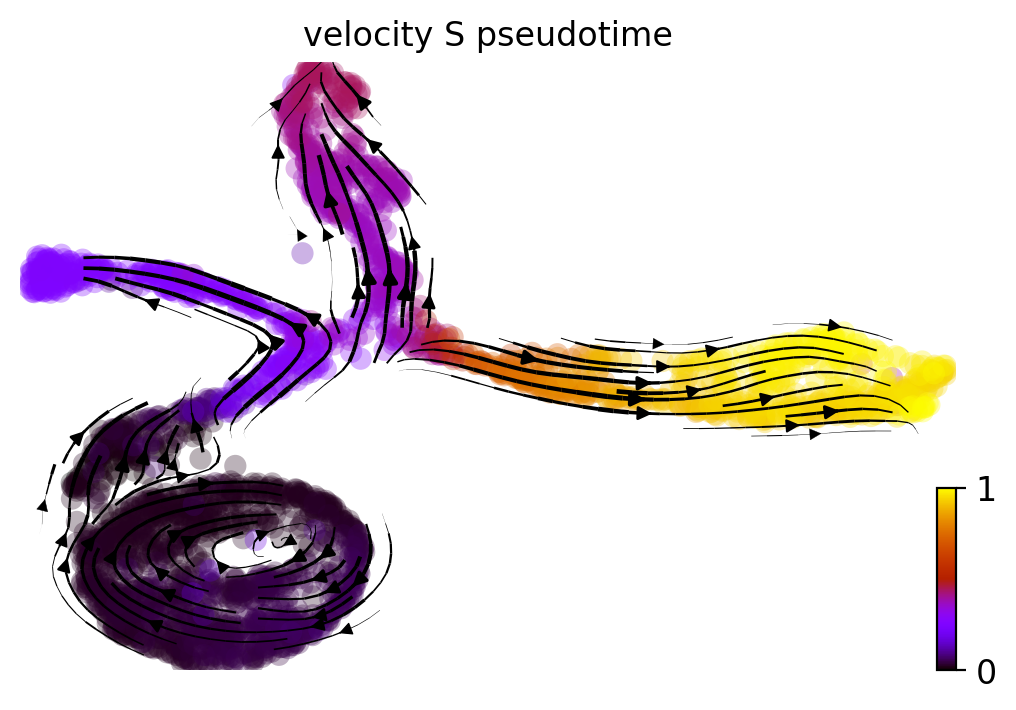

In [27]:
scv.pl.velocity_embedding_stream(adata, 
                                 color='velocity_S_pseudotime', 
                                 basis='umap', 
                                 cmap='gnuplot',
                                )

In [4]:
scv.tl.score_genes_cell_cycle(adata)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


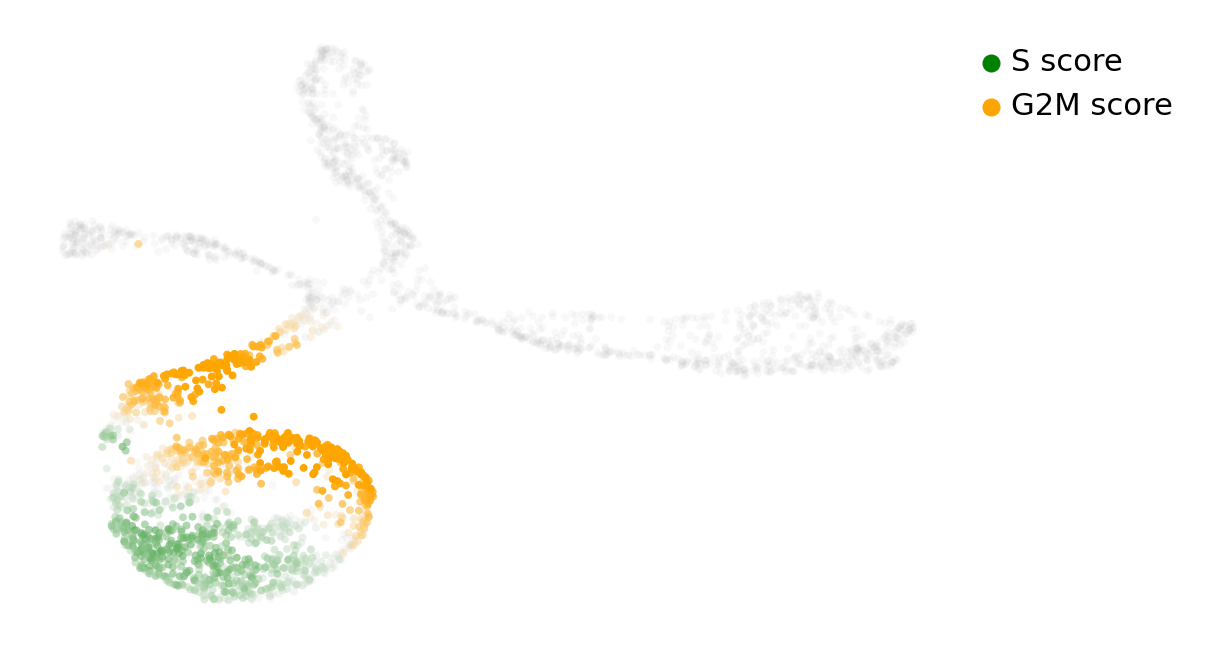

In [9]:
scv.pl.scatter(adata, 
               color_gradients=['S_score', 'G2M_score'], 
               palette=['green', 'orange'], 
               smooth=True, perc=[5, 90])

In [29]:
toptransition_genes = adata.var['use_for_transition'].sort_values(ascending=False).index[:100]

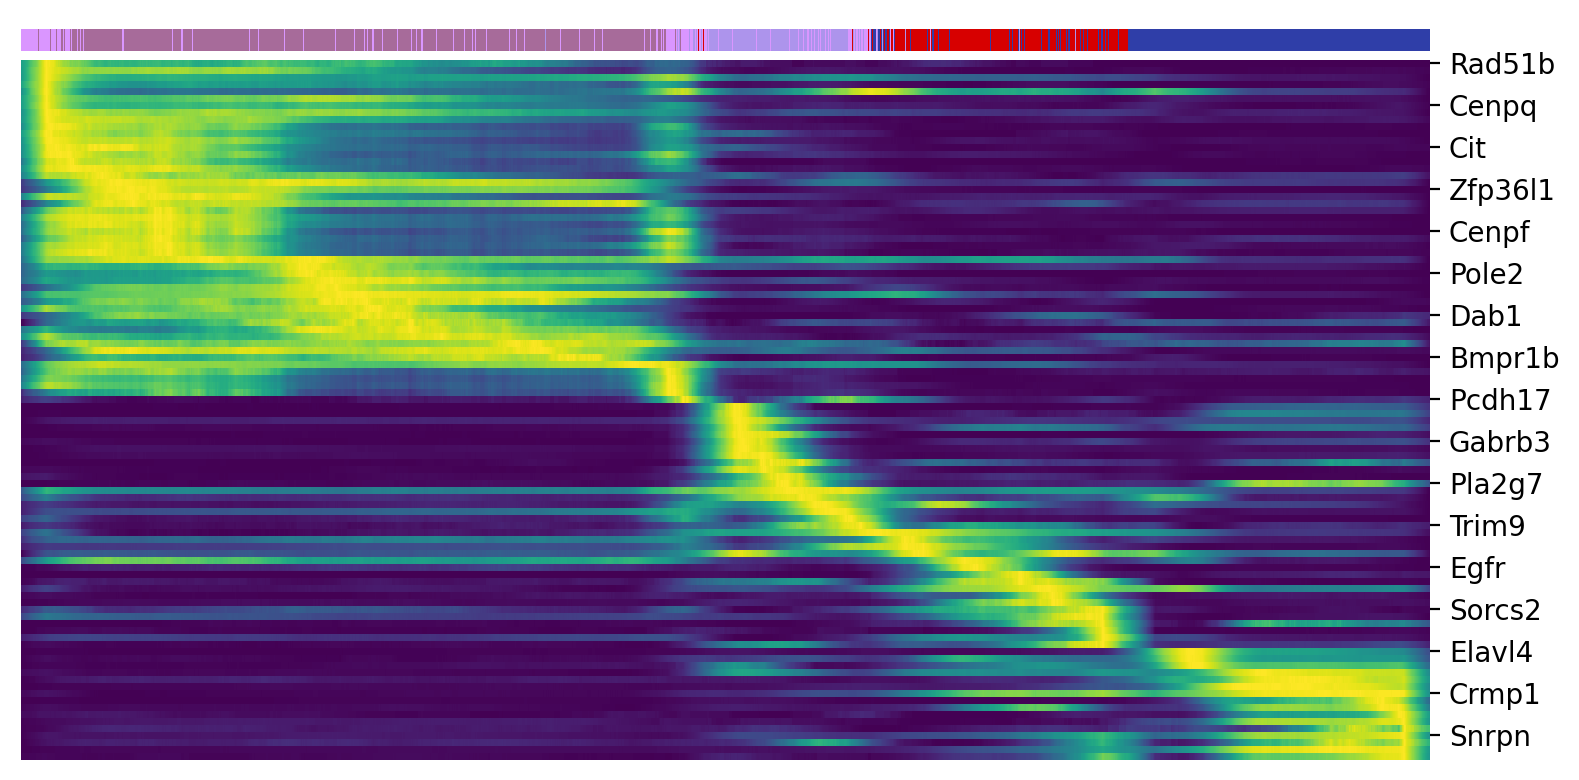

In [35]:
scv.pl.heatmap(adata, 
               var_names=toptransition_genes, 
               sortby='velocity_S_pseudotime', 
               layer='M_s',
               color_map='viridis',
               col_color='Annotation', 
               palette='viridis', 
               n_convolve=100,
               colorbar=True,
               col_cluster=False, 
               row_cluster=False, 
               )